In [3]:
%load_ext autoreload 
%autoreload 2
import benchml as bml
import numpy as np
log = bml.log

## Defining new models

In [ ]:
from benchml.hyper import GridHyper, BayesianHyper, Hyper

def build_linear():
    return bml.pipeline.Module(
        tag="Linear",
        transforms=[
            bml.transforms.ExttInput(),
            bml.transforms.CleanMatrix(
                inputs={
                    "X":"ExttInput.X"
                }),
            bml.transforms.LinearRegression(
                inputs={
                    "X": "CleanMatrix.X",
                    "y": "ExttInput.Y"
                })
        ],
        outputs={"y":"LinearRegression.y"})

def build_ridge():
    return bml.pipeline.Module(
        tag="Ridge",
        transforms=[
            bml.transforms.ExttInput(),
            bml.transforms.CleanMatrix(
                inputs={
                    "X":"ExttInput.X"
                }),
            bml.transforms.Ridge(
                inputs={
                    "X": "CleanMatrix.X",
                    "y": "ExttInput.Y"
                })
        ],
        hyper=BayesianHyper(
            Hyper({"Ridge.alpha": np.linspace(-7,7,15)}),
            convert={"Ridge.alpha": (lambda p: 10**p)}
        ),
        outputs={"y":"Ridge.y"})

def build_mp():
    return bml.pipeline.Module(
        tag="MarchenkoLinear",
        transforms=[
            bml.transforms.ExttInput(),
            bml.transforms.CleanMatrix(
                args={
                    "axis": 0, 
                    "std_threshold": 1e-10
                },
                inputs={
                    "X":"ExttInput.X"
                }),
            bml.transforms.MarchenkoPasturFilter(
                args={
                     "monomials": [1,2]
                },
                inputs={
                    "X":"CleanMatrix.X"
                }),
            bml.transforms.LinearRegression(
                inputs={
                    "X": "MarchenkoPasturFilter.X",
                    "y": "ExttInput.Y"
                })
        ],
        hyper=GridHyper(
            Hyper({"CleanMatrix.std_threshold": [1e-10, 0.5]}),
            Hyper({"MarchenkoPasturFilter.monomials": [ [1], [2], [1,2] ]})
        ),
        outputs={"y":"LinearRegression.y"})

def build_rf():
    return bml.pipeline.Module(
        tag="RandomForest",
        transforms=[
            bml.transforms.ExttInput(),
            bml.transforms.RandomForestRegressor(
                tag="predictor",
                args={
                    "n_estimators": 10
                },
                inputs={"X": "ExttInput.X", "y": "ExttInput.Y"}),
        ],
        hyper=GridHyper(
            Hyper({"predictor.max_depth": [2,4,8]})
        ),
        broadcast={},
        outputs={"y": "predictor.y"})

def build_models():
    return [
        build_linear(),
        build_ridge(),
        build_rf(),
        build_mp()
    ]


## GridHyper and BayesianHyper

In [ ]:
grid = GridHyper(
    Hyper({"descriptor_atomic.normalize": [False, True]}),
    Hyper({"descriptor_atomic.rcut": np.linspace(2.0, 7.5, 12) }),
    Hyper({"descriptor_atomic.nmax": [ 6, 7, 8, 9, 10 ]}),
    Hyper({"descriptor_atomic.lmax": [ 4, 5, 6, 7 ]}),
    Hyper({"descriptor_atomic.sigma": [ 0.25, 0.5, 0.75 ]}),
    Hyper({"descriptor_atomic.part_sigma": [ 0.25, 0.5, 0.75 ]}),
    Hyper({"descriptor_atomic.wconstant": [False, True]}),
    Hyper({"descriptor_atomic.wscale": [ 0.5, 1.0, 1.5 ]}),
    Hyper({"descriptor_atomic.wcentre": [ 0.5, 1.0, 1.5 ]}),
    Hyper({"descriptor_atomic.ldamp": [0.5, 1.0, 2.0, 4.0]}),
    Hyper({"descriptor_atomic.heavy_only": [False, True]}),
    Hyper({"predictor.power": [1, 2, 3, 4]}),
    Hyper({
        "descriptor.reduce_op": ["mean", "sum", "sum"],
        "descriptor.normalize": [False, False, True]
    }),
)

In [ ]:
print(grid.random())
# >>> for repeat, setting in enumerate(grid):
# >>>     print(setting)
# >>>     if repeat > 10: break

## Stand-alone transforms

In [ ]:
from benchml.transforms import CleanMatrix

def make_data():
    return np.random.normal(
        loc=np.random.uniform(size=(10,)), 
        scale=np.random.uniform(size=(10,)), 
        size=(10,10))
                            
X_train = make_data()
X_probe = make_data()

whiten = CleanMatrix().detach(std_threshold=1e-3, axis=0)
whiten.fit(X=X_train)
whiten.map(X=X_probe)

## Listing transforms and models

In [ ]:
trafos = list(bml.transforms.get_all())
_ = [ print("%2d" % idx, t.__name__) for idx, t in enumerate(trafos) ]

In [ ]:
bml.models.list_all()

In [ ]:
model = bml.models.get("logd_delta_hybrid_gylm_krr").pop()
model.showHelpMessage()

## Inspecting a model

In [ ]:
model = build_mp()
print(model)

In [ ]:
args = model.compileArgs()
print("Args =")
_ = [ print("  %-40s = %-10s" % (k,v)) for k, v in args.items() ]

In [ ]:
model.showHelpMessage()

## Fitting a model

In [ ]:
def fit_evaluate_model(
        model, 
        dataset, 
        metrics=["mae", "r2", "rhop"],
        split=dict(method="random", n_splits=10, train_fraction=0.9)):
    accu = bml.Accumulator(metrics=metrics)
    with bml.stream(model, dataset) as stream:
        for idx, (train, test) in enumerate(stream.split(**split)):
            model.fit(train)
            output_train = model.map(train)
            output_test = model.map(test)
            accu.append("train", output_train["y"], train["ExttInput.Y"])
            accu.append("test", output_test["y"], test["ExttInput.Y"])
        print("Accumulated metrics:")
        res = accu.evaluateAll(log=bml.log, bootstrap=0)
    return model, res

In [ ]:
dataset = bml.load_dataset("ising.extt")
print(dataset)
model = build_mp()
model, res = fit_evaluate_model(model, dataset)
print(model)

In [ ]:
bml.splits.synchronize(0)
models = build_models()
timer = bml.utils.StagedTimer()
for m in models:
    print("Evaluate model '%s'" % m.tag)
    with timer.time(m.tag):
        model, res = fit_evaluate_model(m, dataset)
print("Wall times:")
timer.report(log)

## Hyperfitting and benchmarking

In [ ]:
def hyperfit_evaluate_model(
        model, 
        dataset, 
        accu,
        split=dict(method="random", n_splits=1, train_fraction=0.9),
        hypersplit=dict(method="random", n_splits=10, train_fraction=0.8)):
    with bml.stream(model, dataset) as stream:
        for idx, (train, test) in enumerate(stream.split(**split)):
            if model.hyper is not None:
                model.hyperfit(
                    stream=train,
                    split_args=hypersplit,
                    accu_args=dict(metric=accu.metrics[0]),
                    target="y",
                    target_ref="ExttInput.Y",
                    log=log)
            else:
                model.fit(stream=train)
            output_train = model.map(train)
            output_test = model.map(test)
            accu.append("%s_train" % model.tag, output_train["y"], train["ExttInput.Y"])
            accu.append("%s_test" % model.tag, output_test["y"], test["ExttInput.Y"])
    return res

In [ ]:
models = build_models()
accu = bml.Accumulator(metrics=["r2", "r2", "rhop"])
timer = bml.utils.StagedTimer()
for m in models:
    print("Evaluate model '%s'" % m.tag)
    with timer.time(m.tag):
        res = hyperfit_evaluate_model(m, dataset, accu)
print("Accumulated metrics:")
res = accu.evaluateAll(log=bml.log, bootstrap=0)

In [ ]:
timer.report(log)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plot
plot.style.use('seaborn-white')
fig, ax = plot.subplots(1, 4, sharex='col', sharey='row', figsize=(16,4))
for midx, m in enumerate(models):
    yp, yt = accu["%s_test" % m.tag]
    yp_train, yt_train = accu["%s_train" % m.tag]
    ax[midx].scatter(yp, yt, c='#0066ff')
    ax[midx].scatter(yp_train, yt_train, s=1.0, c='#333333')
    ax[midx].set_title(m.tag)

## Train and deploy

In [ ]:
model = build_mp()
with bml.stream(model, dataset) as stream:
    if model.hyper is not None:
        model.hyperfit(
            stream=stream,
            split_args=dict(method="kfold", k=10),
            accu_args=dict(metric="r2"),
            target="y",
            target_ref="ExttInput.Y",
            log=log)
    else:
        model.fit(stream)
bml.save("model.arch", model)

In [ ]:
model = bml.load("model.arch")
model.showHelpMessage()
with bml.stream(model, dataset) as stream:
    output = model.map(stream)
print(output)

## Ensembling and conformal predictions

In [4]:
from benchml.transforms import *

def build_conformal_mp():
    return Module(
        tag="MarchenkoConformal",
        transforms=[
            ExttInput(tag="input"),
            CleanMatrix(
                tag="clean",
                args={
                    "axis": 0,
                    "std_threshold": 1e-10
                },
                inputs={"X":"input.X"}),
            MarchenkoPasturFilter(
                tag="descriptor",
                args={},
                inputs={"X":"input.X"}),
            LinearRegression(
                tag="linear",
                detached=True,
                args={}),
            EnsembleRegressor(
                tag="ensemble",
                detached=True,
                args={
                    "size": 100,
                    "forward_inputs": {"X":"X", "y":"y"}, # = default
                    "input_type": "descriptor"
                },
                inputs={"base_transform": "linear"}),
            ConformalRegressor(
                tag="predictor",
                args={
                    "forward_inputs": {"X":"X", "y":"y"}, # = default
                    "input_type": "descriptor"            # = default
                },
                inputs={
                    "X": "descriptor.X",
                    "y": "input.Y",
                    "base_transform": "ensemble"
                })
        ],
        broadcast={},
        outputs={"y": "predictor.y", "dy": "predictor.dy"})

def build_ensemble_mp():
    return Module(
        tag="MarchenkoEnsemble",
        transforms=[
            ExttInput(tag="input"),
            CleanMatrix(
                tag="clean",
                args={
                    "axis": 0,
                    "std_threshold": 1e-10
                },
                inputs={"X":"input.X"}),
            MarchenkoPasturFilter(
                tag="descriptor",
                args={},
                inputs={"X":"input.X"}),
            LinearRegression(
                tag="linear",
                detached=True,
                args={}),
            EnsembleRegressor(
                tag="predictor",
                args={
                    "size": 100,
                    "forward_inputs": {"X":"X", "y":"y"}, # = default
                    "input_type": "descriptor"
                },
                inputs={
                    "X": "descriptor.X", 
                    "y": "input.Y", 
                    "base_transform": "linear"})
        ],
        broadcast={},
        outputs={"y": "predictor.y", "dy": "predictor.dy"})

def build_mp_models():
    return [
        build_ensemble_mp(),
        build_conformal_mp()
    ]

models = build_mp_models()

In [5]:
dataset = bml.load_dataset("ising.extt")
split = dict(method="random", n_splits=1, train_fraction=0.9)
print(dataset)

ExttDataset with 4 arrays: Array[X(101, 100)] Array[Y(101,)] Array[J(100, 100)] Array[V(100,)] 


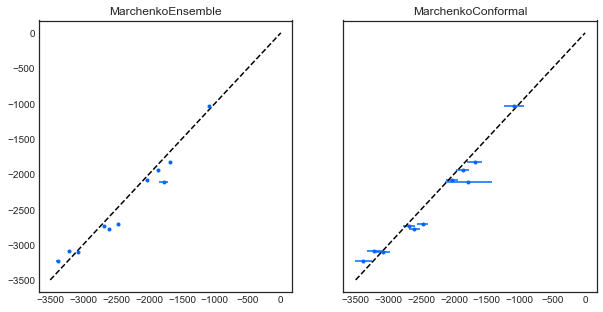

In [6]:
%matplotlib inline
import matplotlib.pyplot as plot
plot.style.use('seaborn-white')
fig, ax = plot.subplots(1, 2, sharex='col', sharey='row', figsize=(10,5))

def add_to_plot(model, test, ax):
    output = model.map(test)
    yt = test["input.Y"]
    yp = output["y"]
    dy = output["dy"]
    ax.errorbar(yp, yt, xerr=dy, c='#0066ff', linestyle='none', fmt='.')
    ax.plot([-3500,0], [-3500,0], 'k--')
    ax.set_title(model.tag)

bml.splits.synchronize(0)
for midx, model in enumerate(models):
    with bml.stream(model, dataset) as stream:
        for idx, (train, test) in enumerate(stream.split(**split)):
            model.fit(train)
            add_to_plot(model, test, ax[midx])